# Predicting 'Fit Feedback' for Rent the Runway Data

This project demonstrates the setup for a machine learning experiment aimed at predicting the 'fit feedback' for Rent the Runway products. The task involves analyzing a dataset containing user reviews and product details to predict whether a particular item will "fit" a user, based on various features like body type, size, age, and textual reviews. Several machine learning models and deep learning techniques are explored to solve this problem, including traditional classifiers like XGBoost, CatBoost, and Logistic Regression, as well as modern neural network-based models such as PyTorch and TabNet.

The goal of this experiment is to explore the performance of different algorithms on predicting how well a product fits a user, an important aspect of Rent the Runway’s business. Predicting fit accurately can help improve customer satisfaction by recommending the most suitable sizes for users.

## Project Overview

The project is structured in the following steps:
1. **Data Collection and Exploration**: Load and inspect the dataset to understand its structure and identify any issues (e.g., missing values, unbalanced classes).
2. **Data Preprocessing**: Clean and transform the data, including feature extraction, handling missing values, encoding categorical variables, and normalizing numerical features.
3. **Model Training**: Train multiple machine learning models and deep learning architectures to predict the 'fit feedback' based on the available features.
4. **Evaluation**: Compare the performance of the models using metrics like accuracy and F2 score, and analyze the results to draw conclusions.

In [1]:
!pip install xgboost

In [2]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.2 MB/s eta 0:00:00


In [3]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.3 MB/s eta 0:00:00


## Machine Learning Experiment Setup

This script demonstrates the setup for a machine learning experiment using various libraries and classifiers, including PyTorch, XGBoost, CatBoost, and deep forest.

## Prerequisites
Before running the script, ensure that the required Python packages are installed.

In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer

In [5]:
import json
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import catboost
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from pytorch_tabnet.tab_model import TabNetClassifier

In [6]:
import warnings
warnings.filterwarnings("ignore")

## Dataset Loading and Initial Exploration

### File Path
The dataset is stored in the file `renttherunway_final_data.json`.

### Reading the Dataset
A function was implemented to read JSON lines data into a Python list.


In [7]:
# File paths
file1 = "renttherunway_final_data.json"

# Function to read JSON lines data from a file
def read_json_lines(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))  # Load each JSON object per line
    return data

# Load data from each file
renttherunway_data = read_json_lines(file1)

# Display the data (printing just the first entry for readability)
print("Rent the Runway Data Sample:", renttherunway_data[0])

Rent the Runway Data Sample: {'fit': 'fit', 'user_id': '420272', 'bust size': '34d', 'item_id': '2260466', 'weight': '137lbs', 'rating': '10', 'rented for': 'vacation', 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.", 'body type': 'hourglass', 'review_summary': 'So many compliments!', 'category': 'romper', 'height': '5\' 8"', 'size': 14, 'age': '28', 'review_date': 'April 20, 2016'}


## Rent the Runway Data Preprocessing and Exploratory Analysis

A detailed exploratory data analysis (EDA) is available in the `Data_Analysis.ipynb` file.

1. The dataset contains 192,544 records, with a detailed statistical summary of the `user_id`, `item_id`, `rating`, `size`, and `age` fields provided.

2. Null values were identified in several fields, such as `bust size` (18,411), `weight` (29,982), `rating` (82), and others. After removing rows with null values, the cleaned dataset contains 146,381 records.

3. The preprocessing steps include:
   - Parsing `bust size` into numerical features (`band_size` and `cup_size`).
   - Extracting numeric values from `weight` and converting `height` to inches.
   - Encoding categorical fields like `body type` and `rented for`.
   - Dropping rows with missing or invalid values in critical columns.

4. The cleaned dataset is summarized with updated statistical descriptions, and all null values are eliminated.

5. A correlation matrix was generated for numerical fields in the dataset, visualized using a heatmap.

6. The dataset was split into training (70%), validation (15%), and test (15%) sets, with shapes of `(94,848, 21)`, `(20,325, 21)`, and `(20,325, 21)`, respectively.

7. Label distributions (`fit`, `small`, `large`) in the training, validation, and test sets were computed, showing an imbalance with the `fit` class being the most frequent.

8. The `fit` column was encoded for classification tasks using a label encoder.


In [8]:
len(renttherunway_data)

192544

In [9]:
renttherunway_df = pd.read_json(file1, lines=True)
renttherunway_df.describe()

,user_id,item_id,rating,size,age
count,192544.000000,1.925440e+05,192462.000000,192544.000000,191584.000000
mean,499494.100149,1.045684e+06,9.092371,12.245175,33.871017
std,289059.719328,8.053148e+05,1.430044,8.494877,8.058083
min,9.000000,1.233730e+05,2.000000,0.000000,0.000000
25%,250654.250000,1.950760e+05,8.000000,8.000000,29.000000
50%,499419.000000,9.483960e+05,10.000000,12.000000,32.000000
75%,750974.000000,1.678888e+06,10.000000,16.000000,37.000000
max,999997.000000,2.966087e+06,10.000000,58.000000,117.000000


In [10]:
print(f" Null values in Renttherunway dataset: \n{renttherunway_df.isnull().sum()}")

 Null values in Renttherunway dataset: 
fit                   0
user_id               0
bust size         18411
item_id               0
weight            29982
rating               82
rented for           10
review_text           0
body type         14637
review_summary        0
category              0
height              677
size                  0
age                 960
review_date           0
dtype: int64


In [11]:
# Remove rows with any null values
cleaned_renttherunway_df = renttherunway_df.dropna()

# Display null values after cleaning to verify
cleaned_null_values = cleaned_renttherunway_df.isnull().sum()
print(f"\nNull values in Renttherunway dataset after cleaning:\n{cleaned_null_values}")

# Summary of cleaned dataset
cleaned_summary = cleaned_renttherunway_df.describe()
cleaned_summary


Null values in Renttherunway dataset after cleaning:
fit               0
user_id           0
bust size         0
item_id           0
weight            0
rating            0
rented for        0
review_text       0
body type         0
review_summary    0
category          0
height            0
size              0
age               0
review_date       0
dtype: int64


,user_id,item_id,rating,size,age
count,146381.000000,1.463810e+05,146381.000000,146381.000000,146381.000000
mean,498991.574528,1.052277e+06,9.081985,11.437919,34.089800
std,289658.524623,8.091076e+05,1.437853,7.826784,8.113217
min,9.000000,1.233730e+05,2.000000,0.000000,0.000000
25%,249294.000000,1.956130e+05,8.000000,4.000000,29.000000
50%,499034.000000,9.618190e+05,10.000000,9.000000,32.000000
75%,750840.000000,1.687082e+06,10.000000,16.000000,37.000000
max,999997.000000,2.966087e+06,10.000000,58.000000,117.000000


In [12]:
##### Transform the nan-numerical features to the numerical label.

def preprocess_data(df):
    # Convert bust size (e.g., '34D') into numerical features
    def parse_bust_size(bust):
        if isinstance(bust, str) and re.match(r'^\d+[A-Z]$', bust.upper()):  # Validate format like '34D'
            bust = bust.upper()  # Normalize to uppercase
            band, cup = int(bust[:-1]), bust[-1]
            cup_size = ord(cup) - ord('A') + 1  # A=1, B=2, C=3, ...
            return band, cup_size
        return None, None

    df['band_size'], df['cup_size'] = zip(*df['bust size'].apply(parse_bust_size))

    # Convert weight (e.g., '137lbs') to numerical
    df['weight_numeric'] = df['weight'].str.extract(r'(\d+)').astype(float)  # Extract numeric part

    # Convert height (e.g., '5\' 8"') to inches
    def height_to_inches(height):
        if isinstance(height, str) and re.match(r'^\d+\' \d+"$', height):
            height = height.replace('"', '').replace("'", "")  # Remove double quotes and apostrophe
            feet, inches = map(int, height.split())
            return feet * 12 + inches
        return None

    df['height_inches'] = df['height'].apply(height_to_inches)

    # Encode body type
    body_type_mapping = {v: i for i, v in enumerate(df['body type'].dropna().unique())}
    df['body_type_encoded'] = df['body type'].map(body_type_mapping)

    # Encode rented for
    rented_for_mapping = {v: i for i, v in enumerate(df['rented for'].dropna().unique())}
    df['rented_for_encoded'] = df['rented for'].map(rented_for_mapping)

    # Drop or fill missing values
    df = df.dropna(subset=['band_size', 'cup_size', 'weight_numeric', 'height_inches',
                           'body_type_encoded', 'rented_for_encoded', 'fit'])

    return df

# Apply preprocessing to the dataset
cleaned_df = preprocess_data(cleaned_renttherunway_df)

# Check the updated dataset
print(cleaned_df.head())


   fit  user_id bust size  item_id  weight  rating     rented for  \
0  fit   420272       34d  2260466  137lbs    10.0       vacation   
1  fit   273551       34b   153475  132lbs    10.0          other   
3  fit   909926       34c   126335  135lbs     8.0  formal affair   
4  fit   151944       34b   616682  145lbs    10.0        wedding   
5  fit   734848       32b   364092  138lbs     8.0           date   

                                         review_text          body type  \
0  An adorable romper! Belt and zipper were a lit...          hourglass   
1  I rented this dress for a photo shoot. The the...  straight & narrow   
3  I rented this for my company's black tie award...               pear   
4  I have always been petite in my upper body and...           athletic   
5  Didn't actually wear it. It fit perfectly. The...           athletic   

                                     review_summary  ... height size   age  \
0                              So many compliments!  ...

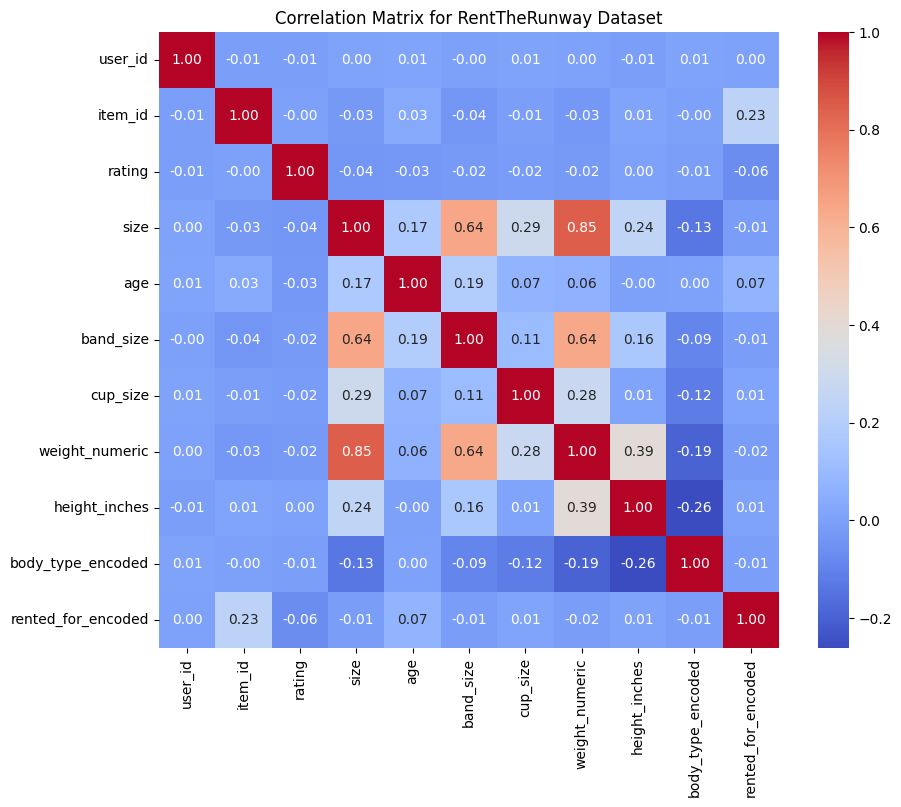

In [13]:
# Correlation matrix for numerical fields in RentTheRunway dataset
renttherunway_corr = cleaned_renttherunway_df.select_dtypes(include=np.number).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(renttherunway_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix for RentTheRunway Dataset")
plt.show()

In [14]:
# Set a random seed for reproducibility
random_seed = 42

# Divide the cleaned dataset into train, validate, and test datasets
train_df, temp_df = train_test_split(cleaned_df, test_size=0.3, random_state=random_seed)  # 70% train
validate_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=random_seed)  # 15% validate, 15% test

# Display the shapes of the resulting datasets
print(f"Train dataset shape: {train_df.shape}")
print(f"Validate dataset shape: {validate_df.shape}")
print(f"Test dataset shape: {test_df.shape}")


Train dataset shape: (94848, 21)
Validate dataset shape: (20325, 21)
Test dataset shape: (20325, 21)


In [15]:
# Distribution of labels (fit, small, large) in the datasets, We can see that the fit, small, large class are not evenly distributed. The fit class is the most.
train_label_distribution = train_df['fit'].value_counts(normalize=True) * 100  # Percentage distribution
validate_label_distribution = validate_df['fit'].value_counts(normalize=True) * 100
test_label_distribution = test_df['fit'].value_counts(normalize=True) * 100

# Create a summary table for label distribution
label_distribution_summary = pd.DataFrame({
    'Train (%)': train_label_distribution,
    'Validate (%)': validate_label_distribution,
    'Test (%)': test_label_distribution
}).fillna(0)  # Fill missing labels with 0

# Display the distribution summary
print("Label Distribution Summary:")
print(label_distribution_summary)


# Ensure 'fit' column is encoded for classification tasks
label_encoder = LabelEncoder()
train_df['fit_encoded'] = label_encoder.fit_transform(train_df['fit'])
validate_df['fit_encoded'] = label_encoder.transform(validate_df['fit'])
test_df['fit_encoded'] = label_encoder.transform(test_df['fit'])

Label Distribution Summary:
       Train (%)  Validate (%)   Test (%)
fit                                      
fit    73.633603     73.638376  73.510455
small  13.297065     13.264453  13.608856
large  13.069332     13.097171  12.880689


In [16]:
##### Ablation study about sample the fit label to make fit, small, large labels evenly distibuted.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Set a random seed for reproducibility
random_seed = 42

# Divide the cleaned dataset into train, validate, and test datasets
train_df, temp_df = train_test_split(cleaned_df, test_size=0.3, random_state=random_seed)  # 70% train
validate_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=random_seed)  # 15% validate, 15% test

# Function to undersample the 'fit' category
def undersample(df):
    # Find the number of samples in the smallest class
    min_class_size = min(df['fit'].value_counts())

    # Sample from each category
    fit_sample = df[df['fit'] == 'fit'].sample(min_class_size, random_state=random_seed)
    small_sample = df[df['fit'] == 'small']
    large_sample = df[df['fit'] == 'large']

    # Combine the samples into a new dataframe
    undersampled_df = pd.concat([fit_sample, small_sample, large_sample]).sample(frac=1, random_state=random_seed)  # Shuffle the dataset
    return undersampled_df

# Apply undersampling to the train, validate, and test datasets
train_df = undersample(train_df)
validate_df = undersample(validate_df)
test_df = undersample(test_df)

# Display the shapes of the resulting datasets
print(f"Train dataset shape: {train_df.shape}")
print(f"Validate dataset shape: {validate_df.shape}")
print(f"Test dataset shape: {test_df.shape}")

# Distribution of labels (fit, small, large) in the datasets
train_label_distribution = train_df['fit'].value_counts(normalize=True) * 100  # Percentage distribution
validate_label_distribution = validate_df['fit'].value_counts(normalize=True) * 100
test_label_distribution = test_df['fit'].value_counts(normalize=True) * 100

# Create a summary table for label distribution
label_distribution_summary = pd.DataFrame({
    'Train (%)': train_label_distribution,
    'Validate (%)': validate_label_distribution,
    'Test (%)': test_label_distribution
}).fillna(0)  # Fill missing labels with 0

# Display the distribution summary
print("Label Distribution Summary:")
print(label_distribution_summary)

# Ensure 'fit' column is encoded for classification tasks
label_encoder = LabelEncoder()
train_df['fit_encoded'] = label_encoder.fit_transform(train_df['fit'])
validate_df['fit_encoded'] = label_encoder.transform(validate_df['fit'])
test_df['fit_encoded'] = label_encoder.transform(test_df['fit'])

Train dataset shape: (37404, 21)
Validate dataset shape: (8020, 21)
Test dataset shape: (8002, 21)
Label Distribution Summary:
       Train (%)  Validate (%)   Test (%)
fit                                      
fit    33.140841      33.19202  32.716821
large  33.140841      33.19202  32.716821
small  33.718319      33.61596  34.566358


## Model Evaluation

Model evaluation is a critical step to assess the effectiveness of different predictive models and their ability to generalize to unseen data. In this case, we applied a variety of models to predict the 'fit feedback' class based on features like body type, size, age, and other encoded attributes. The evaluation is done using two primary metrics: **F2 score** and **Accuracy**.

- **F2 Score**: This is a weighted metric that gives more importance to recall, meaning it is especially useful when the cost of false negatives is higher. It is appropriate when we need to focus on minimizing false negatives and ensuring that most relevant positive instances are identified.

- **Accuracy**: This measures the overall proportion of correct predictions (both true positives and true negatives) in relation to all predictions made. While accuracy is useful, it may not be ideal in imbalanced datasets, where a model could perform well just by predicting the majority class.

#### List of Models Tried:

1. Baseline Models
2. Naïve Bayes Model
3. Logistic Regression Model
4. Distance-Based Models k-NN
5. Stochastic Gradient Descent (SGD)-Based Support Vector Machine (SVM)
6. Latent Factor Model Using Matrix Factorization
7. Gradient Boosting Models XGBoost
8. Gradient Boosting Models CatBoost
9. Random Forest
10. Single Decision Tree
11. Multi-Layer Perceptron
12. Ensemble Learning (Stacking)
13. TabNet Model
14. CNN (Convolutional Neural Network)


### Method 1.1: Baseline Model (Random Guessing)

**Why it’s used:**
This method serves as a baseline to compare the performance of more advanced models. Random guessing helps establish a performance benchmark, showing what results would be expected from a model that does not utilize any features or patterns from the data. By using random guesses, we can evaluate how much improvement a machine learning model can bring over random decisions.

**How it works:**
In this method, random predictions are made by selecting labels from the test set's unique classes. Each label is chosen without considering any input features, so it essentially simulates a model with no predictive power. The F2 score and accuracy of these random predictions are calculated to assess the baseline performance.

### Method 1.2: Baseline Model (Weighted Random Guessing)

**Why it’s used:**
Weighted random guessing improves upon the previous baseline model by incorporating the class distribution from the training set. It simulates a model that considers the prior probabilities of the classes, rather than treating each class equally likely. This method is still random but takes into account the inherent imbalance or frequency distribution of the classes in the training data. It helps measure the effect of class imbalances before applying more sophisticated models.

**How it works:**
In this method, the class labels are not chosen with equal probability but are weighted according to their frequency in the training set. The probability of each class is determined by its relative frequency in the training set, and predictions are made based on these probabilities. After generating the predictions, the F2 score and accuracy are computed to evaluate the performance of this weighted random approach.


In [17]:
## Methond 1.1.
#  Just randomly guess the labels and test the f2 score on the test dataset.

test_y = test_df['fit_encoded']
# Generate random predictions with the same class distribution as the test set
unique_classes = np.unique(test_y)
random_predictions = np.random.choice(unique_classes, size=len(test_y))

accuracy_random = accuracy_score(test_y, random_predictions)

# Compute the F2 score for the random predictions
f2_score_random = fbeta_score(test_y, random_predictions, beta=2, average='weighted')

print(f"Baseline F2 Score (Random Guessing): {f2_score_random:.4f}")
print(f"Baseline Accuracy (Random Guessing) : {accuracy_random:.4f}")

Baseline F2 Score (Random Guessing): 0.3254
Baseline Accuracy (Random Guessing) : 0.3254


In [18]:
## Methond 1.2.
#  Randomly guess the labels based on the appeareance on the training dataset.
#  and test the f2 score on the test dataset.

train_y = train_df['fit_encoded']
test_y = test_df['fit_encoded']
# Calculate the probabilities of each label based on its appearance in the training dataset
label_probabilities = train_y.value_counts(normalize=True)

# Generate random predictions based on the calculated probabilities
weighted_random_predictions = np.random.choice(
    label_probabilities.index, size=len(test_y), p=label_probabilities.values
)

accuracy_weighted_random = accuracy_score(test_y, weighted_random_predictions)
# Compute the F2 score for the weighted random predictions
f2_score_weighted_random = fbeta_score(test_y, weighted_random_predictions, beta=2, average='weighted')

print(f"Baseline F2 Score (Weighted Random Guessing): {f2_score_weighted_random:.4f}")
print(f"Baseline Accuracy (Weighted Random Guessing): {accuracy_weighted_random:.4f}")

Baseline F2 Score (Weighted Random Guessing): 0.3269
Baseline Accuracy (Weighted Random Guessing): 0.3269


### Method 2: Naïve Bayes

**Why it’s used:**
Naïve Bayes is a simple and efficient probabilistic classification algorithm that works well for high-dimensional data and is often used for tasks like text classification, spam detection, and other classification problems where the assumptions of conditional independence between features hold reasonably well. It's a good baseline model to compare with more complex algorithms. This method assumes that the features are conditionally independent given the class label, which simplifies computation and allows the model to perform well with relatively fewer data points.

**How it works:**
Naïve Bayes uses Bayes' Theorem to classify data based on prior probabilities and the likelihood of the features given the class label. It computes the probability of each class given the feature values and selects the class with the highest probability. In this case, since we are using continuous features like 'weight_numeric' and 'height_inches', we use Gaussian Naïve Bayes, which assumes that the continuous features are normally distributed.

The steps involved in implementing Naïve Bayes are:
1. **Data preparation**: Select relevant features and target variable, and scale continuous features to standardize their range.
2. **Model initialization**: Use the `GaussianNB` model from `sklearn`.
3. **Training**: Fit the model to the training data.
4. **Prediction**: Use the trained model to predict the test set labels.
5. **Evaluation**: Calculate performance metrics such as the F2 score and accuracy.

In [19]:
## Methond 2.  Naïve Bayes

# If the features are continuous (e.g., weight_numeric, height_inches), use Gaussian Naïve Bayes.

# Define the features and target variable
# features = ['weight_numeric', 'height_inches', 'band_size', 'cup_size', 'body_type_encoded']
features = ['body_type_encoded']
target = 'fit_encoded'

# Prepare training and test datasets
train_X = train_df[features]
train_y = train_df[target]
test_X = test_df[features]
test_y = test_df[target]

# Standardize the continuous features
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

# Initialize and train the Naïve Bayes model
nb_model = GaussianNB()
nb_model.fit(train_X_scaled, train_y)

# Make predictions on the test set
test_predictions = nb_model.predict(test_X_scaled)

# Compute the F2 score
f2_score_nb = fbeta_score(test_y, test_predictions, beta=2, average='weighted')

# Compute the Accuracy
accuracy_nb = accuracy_score(test_y, test_predictions)

print(f"F2 Score for Naïve Bayes: {f2_score_nb:.4f}")
print(f"Accuracy for Naïve Bayes: {accuracy_nb:.4f}")


F2 Score for Naïve Bayes: 0.2564
Accuracy for Naïve Bayes: 0.3437


### Method 3.1: Logistic Regression Using All Eight Features

#### Why it’s used:
Logistic Regression is a widely used linear model for binary and multiclass classification tasks. It is simple to implement, interpretable, and works well when the relationship between the features and the target variable is linear. Logistic regression is often used as a baseline for classification problems and is effective when there is a linear decision boundary between classes.

#### How it works:
Logistic regression works by estimating the probability of the target variable belonging to a specific class based on the input features. It uses a logistic function (sigmoid) to output values between 0 and 1, which are then used to assign class labels. The model's coefficients are learned through the optimization of a loss function (log-loss) during training. In this case, we use all eight features, including continuous and categorical data encoded as numerical values.

---

### Method 3.2: Logistic Regression using the Best 5 Features (RFE)

#### Why it’s used:
The purpose of using Recursive Feature Elimination (RFE) in this approach is to identify and retain the most important features, improving model performance by reducing complexity and overfitting. Logistic Regression is used here to evaluate how well the top five features predict the target variable, simplifying the model and focusing on key predictors.

#### How it works:
RFE is a feature selection method that recursively removes the least important features based on the model's coefficients. After selecting the top 5 features, the logistic regression model is trained and evaluated using only these features. This process reduces the number of features while retaining the most impactful ones, improving the interpretability and performance of the model.

---

### Method 3.3: Logistic Regression using All Body-Related Features

#### Why it’s used:
In this method, we focus on body-related features such as 'weight_numeric', 'height_inches', 'band_size', 'cup_size', and 'body_type_encoded' to assess their contribution to predicting the "fit" feedback. By reducing the number of features to body-related attributes, the model may provide better insights into the relationship between these specific features and the target variable.

#### How it works:
This method follows the same process as Method 3.1 but limits the features to only body-related ones. The logistic regression model is trained using these selected features, and predictions are made to assess how well these features explain the target variable "fit". The model’s coefficients are analyzed to understand the contribution of each body-related feature.


In [20]:
## Methond 3.1. LogisticRegression model using all eight features
# features = ['weight_numeric', 'height_inches', 'size', 'age', 'band_size', 'cup_size', 'body_type_encoded', 'rented_for_encoded']

# Ensure 'fit' column is encoded for classification tasks
label_encoder = LabelEncoder()
train_df['fit_encoded'] = label_encoder.fit_transform(train_df['fit'])
validate_df['fit_encoded'] = label_encoder.transform(validate_df['fit'])
test_df['fit_encoded'] = label_encoder.transform(test_df['fit'])

# Select relevant features (including preprocessed numerical and encoded features)
features = ['weight_numeric', 'height_inches', 'size', 'age',
            'band_size', 'cup_size', 'body_type_encoded', 'rented_for_encoded']

# Prepare training and testing data
train_X = train_df[features]
train_y = train_df['fit_encoded']
test_X = test_df[features]
test_y = test_df['fit_encoded']

# Fill missing values in features (if any) with the mean
train_X = train_X.fillna(train_X.mean())
test_X = test_X.fillna(test_X.mean())

# Train a Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(train_X, train_y)

# Make predictions on the test data
test_predictions = model.predict(test_X)

# Compute the F2 score
f2_score_test = fbeta_score(test_y, test_predictions, beta=2, average='weighted')

# Compute the Accuracy
accuracy_test = accuracy_score(test_y, test_predictions)

print(f"F2 Score on the test data: {f2_score_test:.4f}")
print(f"Accuracy on the test data: {accuracy_test:.4f}")

# Identify most important factors based on coefficients
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nMost Connected Factors to Fit Feedback:")
print(feature_importance)


F2 Score on the test data: 0.4503
Accuracy on the test data: 0.4608

Most Connected Factors to Fit Feedback:
              Feature  Coefficient
4           band_size     0.011508
0      weight_numeric     0.004713
1       height_inches     0.003104
6   body_type_encoded     0.002828
3                 age     0.002754
2                size    -0.016137
5            cup_size    -0.020502
7  rented_for_encoded    -0.028189


In [21]:
## Methond 3.2. The LogisticRegression model using the best 5 features.

# Purpose:

    # Identify the most important features (using RFE).
    # Build a simpler model using only those features.
    # Evaluate its performance using the F2 score.

# Outcome:

    # A logistic regression model trained on the top 5 features, achieving a specific F2 score on the test set.
    # Insights into which features most strongly influence the "Fit" prediction.

# Select relevant features (including preprocessed numerical and encoded features)
features = ['weight_numeric', 'height_inches', 'size', 'age',
            'band_size', 'cup_size', 'body_type_encoded', 'rented_for_encoded']

# Standardize the features
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_df[features])
test_X_scaled = scaler.transform(test_df[features])
train_y = train_df['fit_encoded']
test_y = test_df['fit_encoded']

# Initialize the Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)

# Recursive Feature Elimination (RFE)
rfe = RFE(model, n_features_to_select=5)  # Select the top 5 features
rfe.fit(train_X_scaled, train_y)

# Display selected features
selected_features = [features[i] for i in range(len(features)) if rfe.support_[i]]
print(f"Selected features by RFE: {selected_features}")

# Standardize the features
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_df[selected_features])
test_X_scaled = scaler.transform(test_df[selected_features])
train_y = train_df['fit_encoded']
test_y = test_df['fit_encoded']

# Initialize the Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(train_X_scaled, train_y)

# Make predictions on the test data
test_predictions = model.predict(test_X_scaled)

# Compute the F2 score
f2_score_test = fbeta_score(test_y, test_predictions, beta=2, average='weighted')

# Compute the Accuracy
accuracy_test = accuracy_score(test_y, test_predictions)

print(f"F2 Score on the test data: {f2_score_test:.4f}")
print(f"Accuracy on the test data: {accuracy_test:.4f}")

# Identify most important factors based on coefficients
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nMost Connected Factors to Fit Feedback:")
print(feature_importance)


Selected features by RFE: ['weight_numeric', 'height_inches', 'size', 'band_size', 'rented_for_encoded']
F2 Score on the test data: 0.4470
Accuracy on the test data: 0.4581

Most Connected Factors to Fit Feedback:
              Feature  Coefficient
0      weight_numeric     0.084898
3           band_size     0.026043
1       height_inches     0.008442
4  rented_for_encoded    -0.053064
2                size    -0.121616


In [22]:
## Methond 3.3. The LogisticRegression model using all body-related features
# features = ['weight_numeric', 'height_inches', 'size', 'age', 'band_size', 'cup_size', 'body_type_encoded', 'rented_for_encoded']

# Select relevant features (including preprocessed numerical and encoded features)
features = ['weight_numeric', 'height_inches', 'size',
            'band_size', 'cup_size', 'body_type_encoded']

# Standardize the features
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_df[features])
test_X_scaled = scaler.transform(test_df[features])
train_y = train_df['fit_encoded']
test_y = test_df['fit_encoded']

# Train a Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(train_X_scaled, train_y)

# Make predictions on the test data
test_predictions = model.predict(test_X_scaled)

# Compute the F2 score
f2_score_test = fbeta_score(test_y, test_predictions, beta=2, average='weighted')

# Compute the Accuracy
accuracy_test = accuracy_score(test_y, test_predictions)

print(f"F2 Score on the test data: {f2_score_test:.4f}")
print(f"Accuracy on the test data: {accuracy_test:.4f}")

# Identify most important factors based on coefficients
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nMost Connected Factors to Fit Feedback:")
print(feature_importance)


F2 Score on the test data: 0.4420
Accuracy on the test data: 0.4548

Most Connected Factors to Fit Feedback:
             Feature  Coefficient
0     weight_numeric     0.094961
3          band_size     0.021944
1      height_inches     0.006228
5  body_type_encoded     0.004659
4           cup_size    -0.021193
2               size    -0.120023


### Method 4.1: Distance-Based Model (Similarity Matching) Euclidean Distance - KNN using All Features

#### Why it’s used:
This method employs the k-Nearest Neighbors (k-NN) algorithm with Euclidean distance to predict the "fit" feedback. All available features, including numerical and categorical values such as 'weight_numeric', 'height_inches', 'size', 'age', and encoded variables like 'body_type_encoded', are considered for prediction. The primary advantage of using k-NN with Euclidean distance is that it can capture the similarity between instances, enabling a more intuitive understanding of how similar data points influence the predicted outcome.

#### How it works:
The k-NN model computes the Euclidean distance between the test data points and all training data points, finding the k-nearest neighbors. The model then makes predictions based on the majority vote (for classification tasks) of these neighbors. Before applying the k-NN algorithm, the features are standardized to ensure proper scaling for the distance calculations. The model is trained using all features, and predictions are made to evaluate the performance using metrics like the F2 score and accuracy.

---

### Method 4.2: Distance-Based Model (Similarity Matching) Euclidean Distance - KNN using Body-Related Features and Size

#### Why it’s used:
This method aims to evaluate the effectiveness of using only body-related features and the 'size' variable in predicting the "fit" feedback. By narrowing the feature set, this approach seeks to explore if focusing on attributes directly related to body measurements and size improves the model's performance, particularly when using the k-NN algorithm with Euclidean distance.

#### How it works:
Similar to Method 4.1, this method applies the k-NN algorithm but only considers body-related features ('weight_numeric', 'height_inches', 'band_size', 'cup_size', 'body_type_encoded') and 'size'. These features are standardized for distance calculation. The k-NN model then makes predictions based on the nearest neighbors, and the results are evaluated using the F2 score and accuracy to determine the predictive power of the selected features. This helps assess whether body-related features alone are sufficient to provide good predictive performance.


In [23]:
## Methond 4.1.  Distance-Based Model (Similarity Matching) Euclidean Distance - KNN
# this model using all features.

# Define the features and target variable
features = ['weight_numeric', 'height_inches', 'size', 'age',
            'band_size', 'cup_size', 'body_type_encoded', 'rented_for_encoded']
target = 'fit_encoded'

# Prepare training and testing data
train_X = train_df[features]
train_y = train_df[target]
test_X = test_df[features]
test_y = test_df[target]

# Standardize the features to ensure proper scaling for distance calculations
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

# Initialize and train the k-NN model
knn_model = KNeighborsClassifier(n_neighbors=5, metric='euclidean')  # Use Euclidean distance as default
knn_model.fit(train_X_scaled, train_y)

# Make predictions on the test set
test_predictions = knn_model.predict(test_X_scaled)

# Compute the F2 score
f2_score_knn = fbeta_score(test_y, test_predictions, beta=2, average='weighted')

# Compute the Accurcay
accuracy_knn = accuracy_score(test_y, test_predictions)

print(f"F2 Score for k-NN Model: {f2_score_knn:.4f}")
print(f"Accuracy for k-NN Model: {accuracy_knn:.4f}")



F2 Score for k-NN Model: 0.3925
Accuracy for k-NN Model: 0.3938


In [24]:
## Methond 4.2.  Distance-Based Model (Similarity Matching) Euclidean Distance - KNN
# this model using the body related features and the size.

# Define the features and target variable
features = ['weight_numeric', 'height_inches', 'band_size', 'cup_size', 'body_type_encoded', 'size']
target = 'fit_encoded'

# Prepare training and testing data
train_X = train_df[features]
train_y = train_df[target]
test_X = test_df[features]
test_y = test_df[target]

# Standardize the features to ensure proper scaling for distance calculations
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

# Initialize and train the k-NN model
knn_model = KNeighborsClassifier(n_neighbors=5, metric='euclidean')  # Use Euclidean distance as default
knn_model.fit(train_X_scaled, train_y)

# Make predictions on the test set
test_predictions = knn_model.predict(test_X_scaled)

# Compute the F2 score
f2_score_knn = fbeta_score(test_y, test_predictions, beta=2, average='weighted')

# Compute the Accurcay
accuracy_knn = accuracy_score(test_y, test_predictions)

print(f"F2 Score for k-NN Model: {f2_score_knn:.4f}")
print(f"Accuracy for k-NN Model: {accuracy_knn:.4f}")


F2 Score for k-NN Model: 0.4064
Accuracy for k-NN Model: 0.4073


### Method 5: SGD-based SVM using Body-Related Features

#### Why it’s used:
This method leverages the Stochastic Gradient Descent (SGD) optimization technique to train a Support Vector Machine (SVM) model for predicting the "fit" feedback. By focusing on body-related features, such as 'weight_numeric', 'height_inches', 'band_size', 'cup_size', 'body_type_encoded', and 'size', this model seeks to assess whether these attributes are sufficient for accurate predictions. The use of SGD for training the SVM allows for efficient optimization, especially in large datasets.

#### How it works:
In this method, the features related to body measurements and size are standardized to ensure proper scaling before training the model. The SGDClassifier is then initialized with the hinge loss function, which is used for linear SVMs. The model is trained on the scaled training data, and predictions are made on the test set. The performance of the model is evaluated using the F2 score and accuracy, which measure the effectiveness of the model in correctly predicting the "fit" feedback. By focusing on body-related features, the model aims to determine the predictive power of these specific attributes for the target variable.


In [25]:
## Methond 5. SGD based SVM
# this model using body related features.

# Define the features and target variable
features = ['weight_numeric', 'height_inches', 'band_size', 'cup_size', 'body_type_encoded', 'size']
target = 'fit_encoded'

# Prepare training and testing data
train_X = train_df[features]
train_y = train_df[target]
test_X = test_df[features]
test_y = test_df[target]

# Standardize the features
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

# Initialize and train the SGDClassifier
sgd_svm = SGDClassifier(loss="hinge", random_state=42, max_iter=1000, tol=1e-3)
sgd_svm.fit(train_X_scaled, train_y)

# Make predictions on the test set
test_predictions = sgd_svm.predict(test_X_scaled)

# Compute the F2 score
f2_score_sgd = fbeta_score(test_y, test_predictions, beta=2, average='weighted')

# Compute the Accuracy
accuracy_sgd = accuracy_score(test_y, test_predictions)

print(f"F2 Score for SGD-based SVM Model: {f2_score_sgd:.4f}")
print(f"Accuracy for SGD-based SVM Model: {accuracy_sgd:.4f}")

F2 Score for SGD-based SVM Model: 0.4202
Accuracy for SGD-based SVM Model: 0.4381


### Method 6: Matrix Factorization for Latent Representations and Classification

#### Why it’s used:
This method applies Matrix Factorization using Latent Factor Decomposition to generate latent representations of the features, which can then be used for classification. Latent factors are useful when we aim to reduce the dimensionality of the data while preserving important patterns, especially when working with high-dimensional features. This approach helps create a compact representation of the data, which can then be classified more efficiently.

#### How it works:
In this method, the features are first standardized for proper scaling. Then, Latent Factor Decomposition is applied using Truncated Singular Value Decomposition (SVD), which reduces the dimensionality of the feature set and creates latent representations. These latent features are then used to train a Logistic Regression model. The model is evaluated using F2 score and accuracy, which assess the model's performance in predicting the "fit" feedback based on the reduced latent features. This approach is particularly useful for understanding hidden relationships in the data while maintaining prediction accuracy.


In [26]:
## Methond 6. For your classification problem (predicting fit feedback: "Small," "Fit," or "Large"),
# we can use a Matrix Factorization approach to create latent representations and then classify based on these representations.

# Define the features and target variable
features = ['weight_numeric', 'height_inches', 'band_size', 'cup_size', 'body_type_encoded', 'size']
target = 'fit_encoded'

# Prepare training and testing data
train_X = train_df[features]
train_y = train_df[target]
test_X = test_df[features]
test_y = test_df[target]

# Standardize the features
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

# Apply Latent Factor Decomposition
n_components = 5  # Number of latent factors
svd = TruncatedSVD(n_components=n_components, random_state=42)
train_X_latent = svd.fit_transform(train_X_scaled)
test_X_latent = svd.transform(test_X_scaled)

# Train a Logistic Regression model on the latent features
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(train_X_latent, train_y)

# Make predictions on the test set
test_predictions = clf.predict(test_X_latent)

# Compute the F2 score
f2_score_latent = fbeta_score(test_y, test_predictions, beta=2, average='weighted')

# Compute the accuracy
accuracy_latent = accuracy_score(test_y, test_predictions)

print(f"F2 Score for Latent-Factor Model: {f2_score_latent:.4f}")
print(f"Accuracy for Latent-Factor Model: {accuracy_latent:.4f}")


F2 Score for Latent-Factor Model: 0.3916
Accuracy for Latent-Factor Model: 0.4058


### Gradient Boosting Models (e.g., XGBoost, CatBoost)
### Method 7: XGBoost Model

#### Why it’s a good fit:
XGBoost is an excellent choice for this classification task as it handles both numerical and categorical data efficiently. It excels at capturing complex interactions between features without requiring extensive preprocessing. As a gradient boosting algorithm, it builds strong models by sequentially combining weak learners (decision trees) and correcting errors from previous iterations, making it effective for structured data with classification problems.

#### How it works:
In this method, we use XGBoost's gradient boosting approach to sequentially combine decision trees, minimizing errors from earlier predictions. The model is trained using the features 'weight_numeric', 'height_inches', 'band_size', 'cup_size', 'body_type_encoded', and 'size'. After training, predictions are made on the test set. The model’s performance is evaluated using the F2 score and accuracy, which indicate its ability to correctly predict the "fit" feedback.

---

### Method 8: CatBoost Model

#### Why it’s a good fit:
CatBoost is designed to handle both numerical and categorical data efficiently, making it a great choice for this classification task. It uses gradient boosting with symmetric trees, reducing overfitting while improving model performance. This makes it particularly effective for classification tasks with structured data, especially when categorical variables are present.

#### How it works:
This method applies CatBoost's gradient boosting approach, which builds decision trees while minimizing overfitting through ordered boosting. The model is trained on features such as 'weight_numeric', 'height_inches', 'band_size', 'cup_size', 'body_type_encoded', and 'size'. After training, predictions are made on the test set. The performance is evaluated using the F2 score and accuracy to assess how well it predicts the "fit" feedback.


In [27]:
## Methond 7. XGBoost

# Define the features and target variable
features = ['weight_numeric', 'height_inches', 'band_size', 'cup_size', 'body_type_encoded', 'size']
target = 'fit_encoded'

# Prepare training and testing data
train_X = train_df[features]
train_y = train_df[target]
test_X = test_df[features]
test_y = test_df[target]

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(random_state=42, n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(train_X, train_y)

# Make predictions on the test set
test_predictions = xgb_model.predict(test_X)

# Compute the F2 score
f2_score_xgb = fbeta_score(test_y, test_predictions, beta=2, average='weighted')

# Compute the Accuracy
accuracy_xgb = accuracy_score(test_y, test_predictions)

print(f"F2 Score for XGBoost Model: {f2_score_xgb:.4f}")
print(f"Accuracy for XGBoost Model: {accuracy_xgb:.4f}")


F2 Score for XGBoost Model: 0.4647
Accuracy for XGBoost Model: 0.4685


In [28]:
# Method 8: CatBoostClassifier

features = ['weight_numeric', 'height_inches', 'band_size', 'cup_size', 'body_type_encoded', 'size']
target = 'fit_encoded'

# Prepare training and testing data
train_X = train_df[features]
train_y = train_df[target]
test_X = test_df[features]
test_y = test_df[target]

# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, verbose=0)

# Fit the model
catboost_model.fit(train_X, train_y)

# Make predictions on the test set
catboost_predictions = catboost_model.predict(test_X)

accuracy_catboost= accuracy_score(test_y, catboost_predictions)

# Compute the F2 score
f2_score_catboost = fbeta_score(test_y, catboost_predictions, beta=2, average='weighted')

print(f"F2 Score for CatBoost Model: {f2_score_catboost:.4f}")
print(f"Accuracy for CatBoost Model: {accuracy_catboost:.4f}")

F2 Score for CatBoost Model: 0.4620
Accuracy for CatBoost Model: 0.4653


### Method 9: Random Forest Model

#### Why it’s a good fit:
Random Forest is an ensemble method that excels at handling non-linear relationships and is robust to noisy features. Unlike single decision trees, it aggregates the predictions of multiple decision trees trained on random subsets of data and features, making it less prone to overfitting. This model is well-suited for structured data where interactions between features can be complex.

#### How it works:
The Random Forest algorithm builds multiple decision trees by randomly sampling subsets of the dataset and the feature space. It then aggregates the predictions of these trees (through majority voting for classification tasks) to improve prediction accuracy. In this approach, the model is trained on features like 'weight_numeric', 'height_inches', 'band_size', 'cup_size', 'body_type_encoded', and 'size'. After training, predictions are made on the test set. Performance is evaluated using the F2 score and accuracy to assess how well the model predicts the "fit" feedback.

In [29]:
## Method 9 Random Forest Model

# Define the features and target variable
features = ['weight_numeric', 'height_inches', 'band_size', 'cup_size', 'body_type_encoded', 'size']
target = 'fit_encoded'

# Prepare training and testing data
train_X = train_df[features]
train_y = train_df[target]
test_X = test_df[features]
test_y = test_df[target]

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rf_model.fit(train_X, train_y)

# Make predictions on the test set
test_predictions = rf_model.predict(test_X)

# Compute the F2 score
f2_score_rf = fbeta_score(test_y, test_predictions, beta=2, average='weighted')

# Compute the Accuracy
accuracy_rf = accuracy_score(test_y, test_predictions)

print(f"F2 Score for Random Forest Model: {f2_score_rf:.4f}")
print(f"Accuracy for Random Forest Model: {accuracy_rf:.4f}")


F2 Score for Random Forest Model: 0.4585
Accuracy for Random Forest Model: 0.4646


### Method 10: Single Decision Tree Model

#### Why it’s a good fit:
A single Decision Tree model is easy to interpret and can capture non-linear relationships between the features. However, it is prone to overfitting, so we limit its depth to prevent this issue. Decision Trees split the data into subsets based on feature values, making them effective for classification tasks with clear decision boundaries.

#### How it works:
In this approach, a Decision Tree is trained on the features 'weight_numeric', 'height_inches', 'band_size', 'cup_size', 'body_type_encoded', and 'size'. The tree makes decisions by recursively splitting the dataset based on feature values. To avoid overfitting, the depth of the tree is constrained. After training, predictions are made on the test set, and the model’s performance is evaluated using the F2 score and accuracy.

In [30]:
## Method 10 Single Decision Tree

# Define the features and target variable
features = ['weight_numeric', 'height_inches', 'band_size', 'cup_size', 'body_type_encoded', 'size']
target = 'fit_encoded'

# Prepare training and testing data
train_X = train_df[features]
train_y = train_df[target]
test_X = test_df[features]
test_y = test_df[target]

# Initialize and train the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)  # Limit depth to avoid overfitting
dt_model.fit(train_X, train_y)

# Make predictions on the test set
test_predictions = dt_model.predict(test_X)

# Compute the F2 score
f2_score_dt = fbeta_score(test_y, test_predictions, beta=2, average='weighted')

# Compute the Accuracy
accuracy_dt = accuracy_score(test_y, test_predictions)

print(f"F2 Score for Decision Tree Model: {f2_score_dt:.4f}")
print(f"Accuracy for Decision Tree Model: {accuracy_dt:.4f}")


F2 Score for Decision Tree Model: 0.4549
Accuracy for Decision Tree Model: 0.4574


### Method 11: MLP (Multi-layer Perceptron)

#### Why it’s a good fit:
Multi-layer Perceptron (MLP) is a neural network model that can capture complex relationships between input features and the target variable. It is a versatile model that works well for classification tasks with structured data, especially when there are nonlinearities or interactions between features. MLP can be particularly beneficial when you have large datasets and want to model intricate relationships between the input and output.

#### How it works:
MLP consists of multiple layers of neurons, where each layer is fully connected to the previous one. The model learns the optimal weights through backpropagation. It uses an adaptive learning rate and can handle both numerical and categorical data if appropriately preprocessed. The model is trained using features such as 'weight_numeric', 'height_inches', 'band_size', 'cup_size', 'body_type_encoded', and 'size'. After training, predictions are made on the test set, and the performance is evaluated using the F2 score and accuracy.

In [31]:
# Method 11: MLP (Multi-layer Perceptron)

# Define the features and target variable
features = ['weight_numeric', 'height_inches', 'band_size', 'cup_size', 'body_type_encoded', 'size']
target = 'fit_encoded'

# Prepare training and testing data
train_X = train_df[features]
train_y = train_df[target]
test_X = test_df[features]
test_y = test_df[target]

# Initialize MLPClassifier (Multi-layer Perceptron)
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, learning_rate='adaptive', random_state=42)

# Fit the model
mlp_model.fit(train_X, train_y)

# Make predictions on the test set
mlp_predictions = mlp_model.predict(test_X)

# Compute the F2 score
f2_score_mlp = fbeta_score(test_y, mlp_predictions, beta=2, average='weighted')
accuracy_mlp=accuracy_score(test_y, mlp_predictions)

print(f"F2 Score for MLP Model: {f2_score_mlp:.4f}")
print(f"F2 Score for MLP Model: {accuracy_mlp:.4f}")


F2 Score for MLP Model: 0.4108
F2 Score for MLP Model: 0.4508


### Method 12: Ensemble Learning (Stacking)

#### Why it’s a good fit:
Stacking is an ensemble learning method that combines multiple base models to improve overall prediction accuracy. It leverages the strengths of different algorithms, allowing the model to perform better than any individual base model. By combining models like XGBoost, Random Forest, and MLP, Stacking can capture different patterns in the data and improve generalization. This method works well when you have diverse models with complementary strengths, making it particularly effective for complex datasets.

#### How it works:
Stacking combines the predictions of several base learners and uses a meta-model to make the final prediction. In this case, XGBoost, Random Forest, and MLP are used as base models, and their predictions are then passed to a logistic regression model, which acts as the meta-model. This process helps improve predictive performance by combining the strengths of each model.

In [32]:
train_df['weight_size_interaction'] = train_df['weight_numeric'] * train_df['size']
test_df['weight_size_interaction'] = test_df['weight_numeric'] * test_df['size']

# Define the features and target variable
features = ['weight_numeric', 'size']
target = 'fit_encoded'

# Prepare training and testing data
train_X = train_df[features]
train_y = train_df[target]
test_X = test_df[features]
test_y = test_df[target]

In [33]:
# Method 12: Ensemble Learning (Stacking)

# Define base models
base_learners = [
    ('xgb', xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.05, max_depth=6, n_estimators=1000)),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000))
]

# Define meta model
meta_model = LogisticRegression()

# Initialize StackingClassifier
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_model)

# Fit the model
stacking_model.fit(train_X, train_y)

# Make predictions on the test set
stacking_predictions = stacking_model.predict(test_X)

accuracy_en = accuracy_score(test_y, stacking_predictions)

# Compute the F2 score
f2_score_stacking = fbeta_score(test_y, stacking_predictions, beta=2, average='weighted')

print(f"F2 Score for Stacking Model: {f2_score_stacking:.4f}")

print(f"Accuracy for Stacking Model: {accuracy_en:.4f}")


F2 Score for Stacking Model: 0.4527
Accuracy for Stacking Model: 0.4538


### Method 13: TabNet

#### Why it’s a good fit:
TabNet is a deep learning model designed specifically for structured/tabular data. It utilizes attention mechanisms to focus on the most relevant features while processing the data. Unlike other deep learning models, TabNet requires less preprocessing and can handle missing values efficiently. Its attention-based structure allows it to interpret the data more flexibly, making it an ideal choice for tabular datasets where feature importance and relationships play a significant role.

#### How it works:
TabNet uses a unique architecture based on attention mechanisms. It processes input features through a series of decision steps, where at each step it decides which features to focus on. This allows TabNet to build a robust representation of the data while maintaining interpretability. It combines the strengths of both traditional machine learning models and deep learning approaches, offering a powerful method for tabular data classification tasks.

In [34]:
# Method 13: TabNet

# Define the features and target variable
features = ['weight_numeric', 'height_inches', 'band_size', 'cup_size', 'body_type_encoded', 'size']
target = 'fit_encoded'

# Prepare training and testing data
train_X = train_df[features]
train_y = train_df[target]
test_X = test_df[features]
test_y = test_df[target]

# Initialize TabNet model
tabnet_model = TabNetClassifier()

# Fit the model
tabnet_model.fit(train_X.values, train_y.values, max_epochs=5, batch_size=1024, virtual_batch_size=128)

# Make predictions on the test set
tabnet_predictions = tabnet_model.predict(test_X.values)

# Compute the F2 score
f2_score_tabnet = fbeta_score(test_y, tabnet_predictions, beta=2, average='weighted')

# Compute the accuracy score
accuracy_tabnet = accuracy_score(test_y, tabnet_predictions)

# Print the results
print(f"F2 Score for TabNet Model: {f2_score_tabnet:.4f}")
print(f"Accuracy for TabNet Model: {accuracy_tabnet:.4f}")


epoch 0  | loss: 1.1023  |  0:00:03s
epoch 1  | loss: 1.05509 |  0:00:05s
epoch 2  | loss: 1.0486  |  0:00:06s
epoch 3  | loss: 1.04571 |  0:00:08s
epoch 4  | loss: 1.04373 |  0:00:09s
F2 Score for TabNet Model: 0.3050
Accuracy for TabNet Model: 0.3347


### Method 14: Convolutional Neural Network (CNN)

#### Why it’s a good fit:
A CNN (Convolutional Neural Network) is typically used for image classification but has also been successful in text classification tasks. In text processing, CNNs can effectively capture local patterns and relationships within text data, making them a suitable choice for tasks like sentiment analysis. In particular, CNNs are able to recognize patterns such as phrases and n-grams, which can be crucial for understanding textual features.

#### How it works:
In this method, the CNN takes input sequences of words, represented as word embeddings, and applies convolutional filters to extract features from various n-grams. After the convolution, max-pooling is performed to extract the most relevant features, which are then passed through a fully connected layer for classification. CNNs can also be trained relatively quickly compared to other deep learning models, making them a practical choice for text classification.

In [35]:
#Method 14: CNN

# Define a custom Dataset for text data
class TextDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = str(self.reviews[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 1e-3

# Load the BERT tokenizer (used only for tokenization)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Split data into train and test sets
train_reviews, test_reviews, train_labels, test_labels = train_test_split(
    train_df['review_text'], train_df['fit_encoded'], test_size=0.2, random_state=42
)

# Create DataLoader
train_dataset = TextDataset(train_reviews.tolist(), train_labels.tolist(), tokenizer, MAX_LEN)
test_dataset = TextDataset(test_reviews.tolist(), test_labels.tolist(), tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Define the CNN model
class TextCNN(nn.Module):
    def __init__(self, num_classes, vocab_size, embedding_dim=100, num_filters=100, filter_sizes=[3, 4, 5]):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embedding_dim)) for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids).unsqueeze(1)  # Add a channel dimension
        conved = [torch.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [torch.max(c, dim=2)[0] for c in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        return self.fc(cat)

# Initialize the CNN model
vocab_size = tokenizer.vocab_size
num_classes = len(set(train_labels))
cnn_model = TextCNN(num_classes=num_classes, vocab_size=vocab_size).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for epoch in range(EPOCHS):
    cnn_model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        outputs = cnn_model(input_ids)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

# Evaluation loop
cnn_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        outputs = cnn_model(input_ids)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the F2 score
f2_score_cnn = fbeta_score(all_labels, all_preds, beta=2, average='weighted')

# Compute the Accuracy
accuracy_cnn = accuracy_score(all_labels, all_preds)

print(f"F2 Score for CNN Model: {f2_score_cnn:.4f}")
# print(f"Accuracy for CNN Model: {accuracy_cnn:.4f}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Epoch 1, Loss: 0.9005060786238084
Epoch 2, Loss: 0.7622800001667606
Epoch 3, Loss: 0.7109239594931276
F2 Score for CNN Model: 0.7030


In [36]:
print(f"Accuracy for CNN Model: {accuracy_cnn:.4f}")

Accuracy for CNN Model: 0.7039
